In [280]:
import pickle as pkl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import hmean
import json
import pandas as pd
import seaborn as sns

plt.style.use('seaborn-v0_8')
# pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
pal = sns.color_palette("deep", 10)


In [281]:
models = {
    "llama3_ft": "ICL-FT",
    "rag_trained": "RAG-FT",
    "gnm": "GNM",
}

model_keys = list(models.keys())
model_names = list(models.values())

In [282]:
model_colors = {
    "Ablation": pal[7],
    "ICL-FT": pal[8],
    "RAG-FT": pal[5],
    "MemLLM": pal[9],
    "GNM": pal[0],
}


# model_colors = sns.color_palette("Paired", n_colors=len(models_list))
# 

# model_colors = {
#     "Base": pal[3],
#     "ICL-FT": '#8D4B2D',
#     "RAG-FT": '#5C7C7A',
#     "MemLLM": '#6B7280',
#     "GNM": '#3B5BDB',
# }

In [283]:
model_keys, model_names

(['llama3_ft', 'rag_trained', 'gnm'], ['ICL-FT', 'RAG-FT', 'GNM'])

In [284]:
data = dict()

for model_key, model_name in models.items():

    data_root = f"../saved_evals/comp_gen_fact_refusals/{model_key}/summary.json"

    # Open the file and load the data
    with open(data_root, 'r') as json_file:
        data_dict = json.load(json_file)

    data[model_key] = data_dict
    data[model_key]["model_name"] = model_name

In [285]:
for model_key, model_name in models.items():

    print(model_key, model_name)

    model_data = data[model_key]
    view_df = pd.DataFrame(model_data)
    display(view_df)

    print("-"*20)

llama3_ft ICL-FT


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,refusal_accuracy,refusal_precision,refusal_precision_over_time,refusal_recall,refusal_recall_over_time,refusal_specificity,model_name
0,3208.0,1.0,1.0,1.0,1.0,0.04,0.04,0.918327,0.918327,0.0,1.100564,4128.0,0.831163,0.820348,0.820348,0.84275,0.84275,0.998201,ICL-FT


--------------------
rag_trained RAG-FT


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,refusal_accuracy,refusal_precision,refusal_precision_over_time,refusal_recall,refusal_recall_over_time,refusal_specificity,model_name
0,3208.0,0.979554,0.979554,0.979554,0.979554,0.250909,0.250909,0.904382,0.904382,0.0,1.125545,4128.0,0.755349,0.687151,0.687151,0.926554,0.926554,1.0,RAG-FT


--------------------
gnm GNM


,compositions,fact_accuracy,fact_accuracy_matrix,fact_accuracy_over_time,fact_retention,fact_selectivity,fact_selectivity_matrix,fact_specificity,fact_specificity_matrix,flops_per_token,loss,non_compositions,refusal_accuracy,refusal_precision,refusal_precision_over_time,refusal_recall,refusal_recall_over_time,refusal_specificity,model_name
0,3208.0,1.0,1.0,1.0,1.0,0.510909,0.510909,0.90239,0.90239,0.0,0.631464,4128.0,0.83814,0.903846,0.903846,0.752354,0.752354,0.973022,GNM


--------------------


In [286]:
len_rollout = 20

rows = []

for k, v in data.items():

    total_score = hmean(
        np.array(
            [
                v["fact_accuracy"],
                v["fact_specificity"],
                v["fact_selectivity"]
            ]
        )
    )[0]
    avg_retention = np.mean(v["fact_retention"])

    total_refusal_score = hmean(
        np.array([
            # v['refusal_accuracy'][0],
            v['refusal_precision'][0],
            v['refusal_recall'][0],
            # v['refusal_specificity'][0],
        ])
    )


    scale = 100

    row = [
        v["model_name"],
        total_score*scale,
        v["fact_accuracy"][0]*scale,
        v["fact_specificity"][0]*scale,
        v["fact_selectivity"][0]*scale,
        total_refusal_score*scale,
        v['refusal_precision'][0]*scale,
        v['refusal_recall'][0]*scale,
    ]

    rows.append(row)

columns = [
    "model_name",  
    "fact_score",
    "fact_accuracy",
    "fact_specificity",
    "fact_selectivity",
    'refusal_score',
    'refusal_precision',
    'refusal_recall',

]

results_df = pd.DataFrame(rows, columns=columns)
results_df.round(1)

,model_name,fact_score,fact_accuracy,fact_specificity,fact_selectivity,refusal_score,refusal_precision,refusal_recall
0,ICL-FT,11.1,100.0,91.8,4.0,83.1,82.0,84.3
1,RAG-FT,49.1,98.0,90.4,25.1,78.9,68.7,92.7
2,GNM,73.8,100.0,90.2,51.1,82.1,90.4,75.2


In [287]:
plot_cols = [
    "fact_score",
    "fact_selectivity",
    "refusal_score"
]

plot_col_labels = [
    "Model",
    "Facts (Overall)",
    "Facts (Sel.)",
    "Refusal (F1)"
]

plot_df = results_df[["model_name"]+plot_cols]
plot_df.columns = plot_col_labels
plot_df

,Model,Facts (Overall),Facts (Sel.),Refusal (F1)
0,ICL-FT,11.074631,4.000000,83.139806
1,RAG-FT,49.082910,25.090909,78.909382
2,GNM,73.792329,51.090908,82.117162


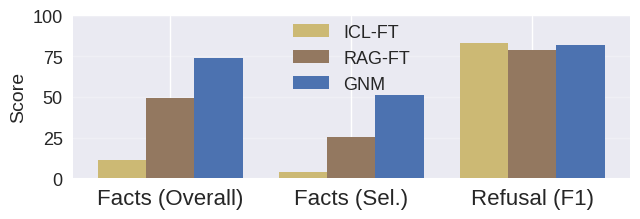

In [ ]:
# Wilson score interval CI function - returns symmetric error for visual consistency
def wilson_ci(p, n, z=1.96):
    """Returns 95% CI half-width using Wilson score interval (p in 0-100 scale).
    Makes error bars visually symmetric by using max of lower/upper error.
    """
    p_prop = p / 100  # Convert percentage to proportion
    
    denom = 1 + z**2 / n
    center = (p_prop + z**2 / (2*n)) / denom
    margin = z * np.sqrt(p_prop * (1 - p_prop) / n + z**2 / (4 * n**2)) / denom
    
    lower = center - margin
    upper = center + margin
    
    # Compute asymmetric errors
    lower_err = max(0, (p_prop - lower) * 100)
    upper_err = max(0, (upper - p_prop) * 100)
    
    # Use the max of the two for symmetric display
    symmetric_err = max(lower_err, upper_err)
    
    return symmetric_err

# Sample count for all metrics
n_samples = 1086

# plot_df columns: ["Model", "Facts", "Facts (Sel.)", "Refusal"]
metrics = [c for c in plot_df.columns if c != "Model"]
models = plot_df["Model"].tolist()
vals = plot_df[metrics].to_numpy()  # shape: (n_models, n_metrics)

x = np.arange(len(metrics))  # xticks are metrics
bar_w = 0.8 / len(models)

fig, ax = plt.subplots(figsize=(6.5, 2.3))

for i, model in enumerate(models):
    # Compute CIs for this model's values
    cis = [wilson_ci(v, n_samples) for v in vals[i, :]]
    
    bars = ax.bar(
        x + (i - (len(models)-1)/2) * bar_w,
        vals[i, :],
        width=bar_w,
        label=model,
        color=model_colors[model],
        yerr=cis,
        capsize=0,
        error_kw={'linewidth': 1.5}
    )
    
    # Add data labels above error bars
    for bar, value, ci in zip(bars, vals[i, :], cis):
        ax.text(bar.get_x() + bar.get_width()/2, value + ci + 2, f'{value:.0f}', 
                ha='center', va='bottom', fontsize=10, fontweight='normal', color='black')

ax.set_xticks(x)
ax.set_ylim(None, 110)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=13)
ax.set_xticklabels(metrics, rotation=0)
ax.set_ylabel("Score", fontsize=14)
# ax.set_title("Compositional Generalization", fontsize=16)
ax.legend(fontsize=13)
ax.grid(axis="y", alpha=0.25)
# set legend location
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=1, fontsize=13)

plt.tight_layout()
plt.savefig("../plots/comp_gen.png", dpi=600)
plt.show()